# Feature extractions from images using a model trained on ImageNet, multiple scales and multiple layers

This notebooks was used to exract features for the featuyre importance study.


# Imports

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import sys
sys.path.append(r'd:\development\napari_convpaint\napari-convpaint\src\napari_convpaint')

In [3]:
%load_ext autoreload
%autoreload 2

import napari
from napari.utils.notebook_display import nbscreenshot

from napari_convpaint.conv_paint import ConvPaintWidget
from napari_convpaint.conv_paint_utils import Hookmodel
from napari_convpaint.convpaint_sample import create_annotation_cell3d

from napari_convpaint.conv_paint_utils import (filter_image_multioutputs, get_features_current_layers,
get_multiscale_features, train_classifier, predict_image, get_features_single_img_rich, 
                                               get_features_all_samples_rich, get_annotation_regions)
 

import numpy as np
import pickle

import torchvision.models as models
import torch

import tifffile
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import pathlib as pl

C:\Users\micstaff\mambaforge\envs\convpaint\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


# Utils

In [5]:
def load_pckl(file_name, path=None):
    if path is not None:
        file_name = os.path.join(path, file_name)

    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    return data


def save_pckl(d, file_name, pr=None, path=None):
    if path is not None:
        file_name = os.path.join(path, file_name)

    with open(file_name, 'wb') as f:
        pickle.dump(d, f, protocol=pr if pr is not None else pickle.DEFAULT_PROTOCOL)

In [6]:
# get mean and std of an array with numpy:
def get_mean_std(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    return x_mean, x_std

# get min and max of an array with numpy:
def get_min_max(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return x_min, x_max

def is_iterable(obj):
    if type(obj) == str:
      return False
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True

def type_len(obj):
    t = type(obj)
    if is_iterable(obj):
        sfx = f', shape: {obj.shape}' if t == np.ndarray else ''
        print(f'type: {t}, len: {len(obj)}{sfx}')
    else:
        print(f'type: {t}, len: {len(obj)}')

## Loading the data - io, paths, and dataset names

First we load an image and the corresponding annotation. We simply display the result as a napari screenshot.

In [8]:
data_root = pl.Path(r'D:\Projects_MV\conv_paint\data')

In [9]:
datasets = [ 'actin', 'fret', 'nuclei', 'spindle', 'worms', 'worms2']
ds = datasets[0]

In [10]:
def get_img_lbl_tmpl(data_root, dataset_name):
    """Get the template for the image and label files of a dataset."""
    n_img = dataset_name+'_img'
    n_lbl = dataset_name+'_mask'
    
    tmpl_img = data_root/n_img/(n_img+r'_%05d.tiff')
    tmpl_lbl = data_root/n_lbl/(n_lbl+r'_%05d.tiff')
    
    return tmpl_img, tmpl_lbl

In [11]:
def read_stack(fn_tmpl, n_max=None):
    """
    Read a stack of images from a template.
    Args:
        fn_tmpl (pathlib.Path or str): template for the file names
        n_max (int): maximum number of files to read from a sequence    
    Returns:
        np.ndarray: stack of images
    """
    ims = []
    i=0
    tmpl = str(fn_tmpl)
    while i>=0:
        try:
            im = tifffile.imread(tmpl % i)
            ims.append(im)
            i += 1
        except FileNotFoundError:
            break
        except Exception as e:
            print(e, type(e))
            break
        if n_max is not None and i == n_max:
            break
    return np.asarray(ims)

Test the functions for loading the data:

In [11]:
tmpl_img, tmpl_lbl = get_img_lbl_tmpl(data_root, ds)
st_img = read_stack(tmpl_img, n_max=None)
st_lbl = read_stack(tmpl_lbl, n_max=None)


In [12]:
st_img.shape, st_img.dtype

((233, 1200, 1200), dtype('uint16'))

In [13]:
st_lbl.shape, st_lbl.dtype

((233, 1200, 1200), dtype('uint16'))

## Create model

The Hookmodel is a wrapper around PyTorch models. It allows to list all modules (layer) of a model and to place "hooks" in order to get the output of chosen layers.

In [144]:
model = Hookmodel(model_name='vgg16')  # uses CUDA if available by default

In [145]:
# check if CUDA is available
model.device

device(type='cpu')

Here is the complete list of modules of the model:

In [146]:
#list(model.module_dict.keys())

From that list we can pick specific layers that will work as feature extractors.
Here we selcted 2 fisrt, 2 last, and one in the middle feature maps after convolutional layers:

In [148]:
layers = ['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.26 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.28 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))'
         ]

Then we add hooks at these layers, i.e. we capture their output. The flow through the network is interrupted at the last selected layer:

In [149]:
model.register_hooks(selected_layers=layers)

`model.features_per_layer` is a list that contains the number of features of each selected layer:

In [150]:
model.features_per_layer

[64, 64, 256, 512, 512]

# Feature extraction

Now that the model is defined, we can run an image through it and recover the outputs at the "hooked" layers. All this is wrapped insisde the ```get_features_current_layers``` function.

In [154]:
sz = 256

In [155]:
ds

'fret'

lets test model featurs on a dummy image to see if it works

In [157]:
img = st_img[0, 0:sz, 0:sz]  # HW
img_3ch = np.stack([img, img, img])  # CHW
img_4ch = img[None]  # BCHW
img_t = torch.tensor(img_4ch, dtype=torch.float32).to(model.device)

In [158]:
img_t.device

device(type='cpu')

In [159]:
img_t.shape

torch.Size([1, 3, 88, 88])

In [160]:
model(img_t).shape

The feature maps per each original image would be huge.
e.g. the st_img[0] has shape (1200, 1200) = 1.44M pixels. with float32 that would be 5.76MB of data.
With our five feature maps that the model outputs with channel number [64, 64, 256, 512, 512] correspondingly, i.e. 1392 channels in total, that would be 8GB of data.
Now in addition to that we have 2 scales, and original and inverted image that would be 8GB * 2 * 2 = 32GB of data per one single image frame.

So to be realistic we 
1. process only `n_proc_frames` frames. these are selected according to the highest standard deviation of the mask. The frames are sorted in descending order of the standard deviation of the mask, every second frame is skipped, and top `n_proc_frames` are selected.
2. process selected frames in crops of size `sz x sz` with step `sz` in both dimensions.
3. the output contains the features only for a subset of the pixels: the ones that are annotated in the mask, same number of pixels randomly selected from the background, and the pixels belonging to the edges of the annotated regions. This greatly reduces the amount of data to be stores.
4. data for each crop is then stored in a separate pickle file.  
 

ds:   0%|          | 0/6 [00:00<?, ?it/s, ds=None, frame=-1, op=Init, x_crop_idx=-1, y_crop_idx=-1]

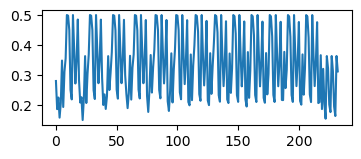

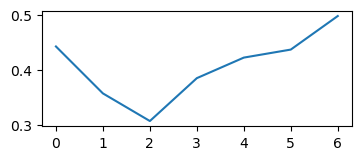

C:\Users\micstaff\mambaforge\envs\convpaint\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\micstaff\mambaforge\envs\convpaint\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\micstaff\mambaforge\envs\convpaint\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


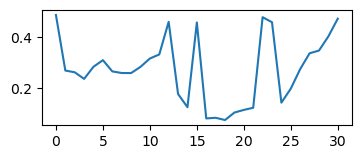

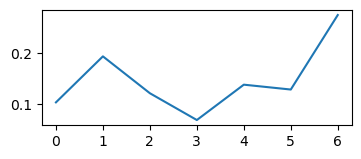

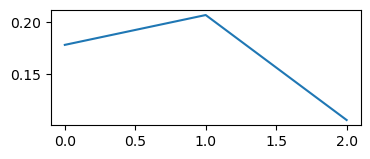

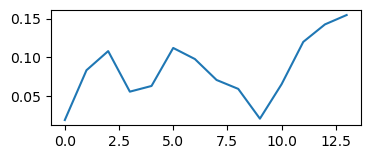

In [181]:
n_proc_frames = 2

pbar = tqdm(datasets, desc='ds', leave=True,
                          postfix={'op':'Init', 'ds': None, 'frame': -1, 'y_crop_idx': -1, 'x_crop_idx': -1}
                         )
for ds in pbar:
    tmpl_img, tmpl_lbl = get_img_lbl_tmpl(data_root, ds)
    st_img = read_stack(tmpl_img, n_max=None)
    st_lbl = read_stack(tmpl_lbl, n_max=None)

    st_img = st_img.astype(np.float32)
    
    mask = st_lbl > 0
    mask_std = np.std(mask, axis=(1, 2))
    
    plt.figure(figsize=(4, 1.5))
    plt.plot(mask_std)
    plt.show()
    plt.close()

    pbar.set_postfix({'op':'Norm', 'ds': ds, 'frame': -1, 'y_crop_idx': -1, 'x_crop_idx': -1})
    st_m, st_s = get_mean_std(st_img)
    st_img -= st_m
    st_img /= st_s
    
    
    ns, h, w = st_img.shape

    idx_of_masks_with_highest_var = np.argsort(mask_std)[::-2]  # every second subsampling
    for i in idx_of_masks_with_highest_var[:n_proc_frames]:
        for j in range(0, h, sz):
            for k in range(0, w, sz):
                pbar.set_postfix({'op':'FeatExtr', 'ds': ds, 'frame': i, 'y_crop_idx': j, 'x_crop_idx': k})
                
                img = st_img[i, j:j+sz, k:k+sz]
                lbl = st_lbl[i, j:j+sz, k:k+sz]
                features_all_samples, targets_all_samples, feature_info = get_features_all_samples_rich(
                    model=model, images=img,
                    annotations=lbl, scalings=[1,2],
                    order=0,
                    add_grad=False, add_rot=False, add_neg=True
                )
                
                if features_all_samples is None:
                    continue
    
                d = {'features': features_all_samples, 'targets': targets_all_samples, 'feature_info': feature_info}
                p = data_root/'features'/ds
                p.mkdir(exist_ok=True, parents=True)
                save_pckl(d, f'features_{i}_{j}_{k}.pckl', path=p)

The `feature_info` is a dictionary that contains information about the features.
You can see that feature sequence is:

raw image 

64 features from first (0) layer (+img), scale 1,
64 features from second (2) layer (+img), scale 1,
256 features from middle (12) layer (+img), scale 1,
512 features from second last (26) layer (+img), scale 1,
512 features from last (28) layer (+img), scale 1,

64 features from first (0) layer (+img), scale 2,
....
....

inverted image

64 features from first (0) layer (-img), scale 1,
....

64 features from first (0) layer (-img), scale 2,
....
512 features from last (28) layer (-img), scale 2,

In [164]:
#d['feature_info']
for k, v in d['feature_info'].items():
    print(k, v[1], v[2], v[6])

0 raw_+_1_1 1 raw
1 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0001 1 orig
2 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0002 1 orig
3 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0003 1 orig
4 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0004 1 orig
5 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0005 1 orig
6 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0006 1 orig
7 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0007 1 orig
8 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0008 1 orig
9 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0009 1 orig
10 features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))_+_1_0010 1 orig
11 features.0 Conv2d(3, 64, kernel_size=(

finally we could concatenate all the features and targets from each dataset into a single array, for example:

In [ ]:
ds = datasets[-1]
p = data_root/'features'/ds

In [67]:
all_features_all_samples = []
all_targets_all_samples = []

for pi in p.glob('*.pckl'):
    d = load_pckl(pi)
    print(d['features'][0].shape)
    features_all_samples, targets_all_samples, feature_info = d['features'][0], d['targets'][0], d['feature_info']
    all_features_all_samples.append(np.asarray(features_all_samples))
    all_targets_all_samples.append(np.asarray(targets_all_samples))
    
all_features_all_samples = np.concatenate(all_features_all_samples, axis=0)
all_targets_all_samples = np.concatenate(all_targets_all_samples, axis=0)

(11342, 1665)
(2432, 1665)
(8598, 1665)
(2994, 1665)
(8674, 1665)
(112, 1665)
(3026, 1665)
(14072, 1665)
(25749, 1665)
(16833, 1665)
(4764, 1665)
(13464, 1665)
(33362, 1665)
(11337, 1665)
(20333, 1665)
(9895, 1665)
(18340, 1665)


In [68]:
all_features_all_samples.shape, all_targets_all_samples.shape

((205327, 1665), (205327,))